In [1]:
# importing dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
plt.style.use('seaborn')


# perform train-test-split - original csv file is imported again to start with a clean df
# import modules

# reading in data as df
df = pd.read_csv('Breast_Cancer.csv', delimiter=',')

# correcting typos
df = df.rename(columns={'T Stage ':'T Stage'})
df = df.rename(columns={'Reginol Node Positive': 'Regional Node Positive'})

# remapping target column
df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})

# changing dtypes of columns as needed
dtypes_columns = {'Age' : 'int64',
'Race' : 'category',
'Marital Status' : 'category',
'T Stage' : 'category', 
'N Stage' : 'category',
'6th Stage' : 'category',
'differentiate' : 'category',
'Grade' : 'category',
'A Stage' : 'category', 
'Tumor Size' : 'int64',
'Estrogen Status' : 'category',
'Progesterone Status' : 'category',
'Regional Node Examined' : 'int64',
'Regional Node Positive' : 'int64',
'Survival Months' : 'int64',
'Status' : 'category',
'Status_encoded' : 'int64'}
df = df.astype(dtypes_columns)

# drop 'Grade' columns because the information is the same as in the 'differentiate' column 
df.drop('Grade', axis=1, inplace=True)

# creating target and features 
target = df.loc[:,'Status_encoded']
features = df.drop('Status', axis=1)
features = features.drop('Status_encoded', axis=1)

# train and test split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

C:\Users\flori\AppData\Local\Temp\ipykernel_11476\2395689806.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(3621, 14)

(403, 14)

(3621,)

(403,)

In [3]:
# creating lists of categorical, ordinal and numerical columns
cat_cols = ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status']
ord_cols = ['T Stage', 'N Stage', '6th Stage', 'differentiate', 'A Stage']
num_cols = [col for col in features_train.select_dtypes(include=["int64","float64"])]

In [4]:
# gridsearch RandomForestClassifier

# choosing features for baseline model
#selected_features = cat_cols + ord_cols + num_cols
# selecting only top 5 features extracted from feature_importance of DecisionTreeClassifier
selected_features = num_cols

# setting up pipeline for OneHotEncoding and OrdinalEncoder
ohe_transformer = OneHotEncoder(drop='if_binary')
ord_transformer = OrdinalEncoder()
transformer = ColumnTransformer([#('cat_transformer', ohe_transformer, cat_cols), 
                                 #('ord_transformer', ord_transformer, ord_cols)
                                ], remainder='passthrough')

# creating model instance
model_rfc = RandomForestClassifier(class_weight='balanced', 
                                   random_state=42, 
                                   n_jobs=-1
                                  )

# creating baseline model pipeline
baseline_model = Pipeline([('preprocessing', transformer),
                           ('model', model_rfc)])

search_space_rfc = {'model__max_depth': np.geomspace(start=1, stop=250, num=10, dtype='int'),
                   'model__min_samples_leaf': np.geomspace(start=1, stop=40, num=10, dtype='int'),
                    'model__n_estimators': np.geomspace(start=25, stop=300, num=10, dtype='int')}

model_rfc = GridSearchCV(estimator=baseline_model,
                        param_grid=search_space_rfc,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)

# fitting model
model_rfc.fit(features_train[selected_features], target_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([  1,   1,   3,   6,  11,  21,  39,  73, 135, 250]),
                         'model__min_samples_leaf': array([ 1,  1,  2,  3,  5,  7, 11, 17, 26, 40]),
                         'model__n_estimators': array([ 25,  32,  43,  57,  75,  99, 131, 172, 227, 300])},
             scoring='f1')

In [5]:
# save best estimator as pickle
import pickle

pickle.dump(model_rfc.best_estimator_, open('model_rfc.best_estimator_.p', 'wb'))

In [6]:
# load best estimator
file_name = 'model_rfc.best_estimator_.p'
with (open(file_name, "rb")) as f:
    pickle.load(f)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=11,
                                        min_samples_leaf=3, n_estimators=172,
                                        n_jobs=-1, random_state=42))])
recall: 0.6571428571428571
precision: 0.7666666666666667
f1: 0.7076923076923077
accuracy: 0.9057071960297767


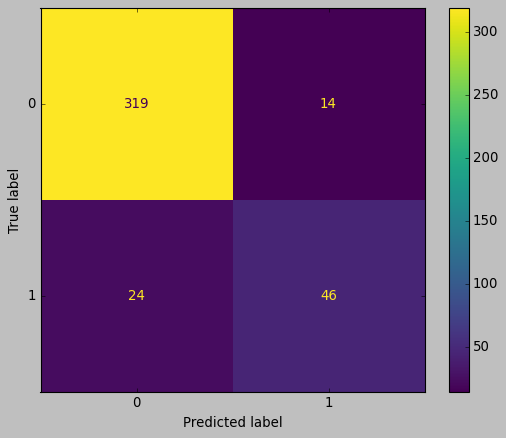

In [7]:
# predict and evaluate on test data
print(model_rfc.best_estimator_)

recall = recall_score(target_test, model_rfc.predict(features_test[selected_features]))
precision = precision_score(target_test, model_rfc.predict(features_test[selected_features]))
f1 = f1_score(target_test, model_rfc.predict(features_test[selected_features]))
accuracy = accuracy_score(target_test, model_rfc.predict(features_test[selected_features]))
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1: {f1}')
print(f'accuracy: {accuracy}')

# confusion matrix for predictions on test data
plt.style.use('classic')
test_pred = model_rfc.best_estimator_.predict(features_test[selected_features])
confusion_matrix(target_test, test_pred)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model_rfc, features_test[selected_features], target_test);

In [8]:

# Best score with all features
# Pipeline(steps=[('transformer',
#                  ColumnTransformer(remainder='passthrough', transformers=[])),
#                 ('model',
#                  RandomForestClassifier(class_weight='balanced', max_depth=25,
#                                         min_samples_leaf=3, n_estimators=209,
#                                         n_jobs=-1, random_state=42))])
# recall: 0.6571428571428571
# precision: 0.7796610169491526
# f1: 0.7131782945736433
# accuracy: 0.9081885856079405

# Best score with only top 5 features extracted from feature_importance of DecisionTreeClassifier
# ['Age', 'Tumor Size', 'Survival Months', 'Regional Node Examined', 'Regional Node Positive']

# Pipeline(steps=[('preprocessing',
#                  ColumnTransformer(remainder='passthrough', transformers=[])),
#                 ('model',
#                  RandomForestClassifier(class_weight='balanced', max_depth=1,
#                                         n_estimators=25, n_jobs=-1,
#                                         random_state=42))])
# recall: 0.6571428571428571
# precision: 0.8214285714285714
# f1: 0.73015873015873
# accuracy: 0.9156327543424317


# Train Models

In [9]:
#problem with models

In [10]:
def feature_engineering(features):
    df = features.copy()
    df.loc[:, "Age_group"] = pd.cut(x=df.loc[:, 'Age'], bins=[30,34,39,44,49,54,59,64,69],
                        labels = ['30-34','35-39','40-44','45-49','50-54','55-59',
                                 '60-64','65-69'])
    df = df.drop('Age', axis=1)
    return df

In [11]:
model_results = []

In [12]:
features_train.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months
598,65,White,Married,T1,N2,IIIA,Moderately differentiated,Regional,20,Positive,Positive,15,5,89
3259,40,White,Married,T3,N2,IIIA,Moderately differentiated,Regional,53,Positive,Positive,13,5,105
2155,63,White,Married,T1,N1,IIA,Poorly differentiated,Regional,15,Positive,Positive,23,2,96
1113,60,White,Single,T1,N1,IIA,Poorly differentiated,Regional,16,Positive,Positive,11,3,62
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,Regional,22,Positive,Negative,11,3,69


In [13]:
pipeline_rf = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_cols),
                    ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=0))])

pipeline_rf.fit(features_train, target_train)

target_test_pred_rf = pipeline_rf.predict(features_test)

scores = {'name': "RandomForestClassifier",
          'accuracy': accuracy_score(target_test,target_test_pred_rf) * 100,
          'precision': precision_score(target_test,target_test_pred_rf) * 100,
          'recall': recall_score(target_test,target_test_pred_rf) * 100,
          'F1': f1_score(target_test,target_test_pred_rf) * 100,
         }
model_results.append(scores)
pd.DataFrame(model_results).T

c:\Users\flori\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0
name,RandomForestClassifier
accuracy,90.57072
precision,88.095238
recall,52.857143
F1,66.071429


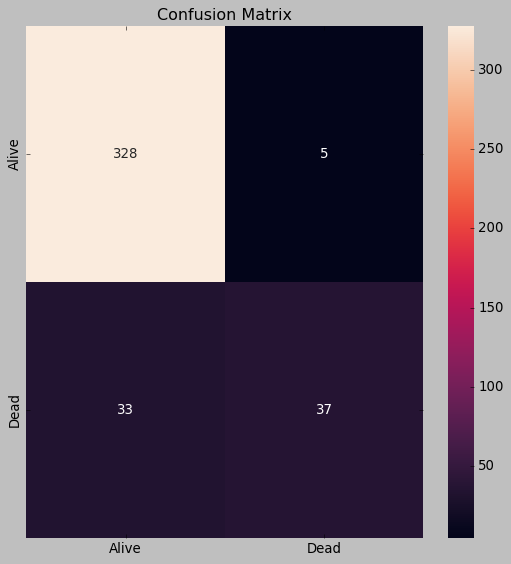

In [14]:
labels = ['Alive', 'Dead']
cm = confusion_matrix(target_test, target_test_pred_rf)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.show()

In [15]:
# report
report = classification_report(target_test, target_test_pred_rf)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       333
           1       0.88      0.53      0.66        70

    accuracy                           0.91       403
   macro avg       0.89      0.76      0.80       403
weighted avg       0.90      0.91      0.90       403



In [18]:
# Run GridSearch with RandomForest

# initiate model


# Create the parameter grid
grid_search_rf = [{'classifier__max_depth':[10,11,12,13,14,15, 20],       
                    'classifier__max_features':[2, 3, 4, 5, 6, 8, 20,"auto"],
                    'classifier__min_samples_split':[2, 3, 4],
                    'classifier__min_samples_leaf':[2, 3, 4]
                  }]

# Create an instance of GridSearch 
grid_rf = GridSearchCV(estimator=pipeline_rf,
                     param_grid = grid_search_rf,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

# Train the RandomForestClassifier
grid_rf.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_rf.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_rf.best_params_)

# Print the val score of the best model
#predict
target_test_pred_rf_grid = grid_rf.best_estimator_.predict(features_test)

#save
scores = {'name': "RandomForest_GridSearch",
          'accuracy': accuracy_score(target_test, target_test_pred_rf_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_rf_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_rf_grid) * 100,
          'F1': f1_score(target_test, target_test_pred_rf_grid) * 100,
          }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

c:\Users\flori\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


best score
0.6280348430317563
best model parameter
{'classifier__max_depth': 14, 'classifier__max_features': 8, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0]

,0,1
name,RandomForestClassifier,RandomForest_GridSearch
accuracy,90.57072,90.57072
precision,88.095238,76.666667
recall,52.857143,65.714286
F1,66.071429,70.769231


In [ ]:
# print roc-curve

# create DataFrame with one column named prediction
df_pred_test = pd.DataFrame(target_test_pred_rf_grid, columns=['prediction'])

# predict probabilities and add them as new column
df_pred_test.loc[:, 'probability'] = grid_rf.best_estimator_.predict_proba(features_test)[:, 1]  

# calculate roc-curve
from sklearn.metrics import roc_curve

false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# plotting
plt.style.use('ggplot')

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--")  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall)

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall");

In [ ]:
# Logistic Regression

# create Pipeline
pipeline_log = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                     ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))])

# fit pipeline on cleaned training set
pipeline_log.fit(features_train, target_train)

# predict and evaluate on test set

#predict
target_test_pred_log = pipeline_log.predict(features_test)

#save
scores = {'name': "LogisticRegression",
          'accuracy': accuracy_score(target_test, target_test_pred_log) * 100,
          'precision': precision_score(target_test, target_test_pred_log) * 100,
          'recall': recall_score(target_test, target_test_pred_log) * 100,
          'F1': f1_score(target_test, target_test_pred_log) * 100,
             }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
# report
report = classification_report(target_test, target_test_pred_log)
print("Classification Report:\n", report)

In [ ]:
# Run GridSearch with LogisticRegression

# creat C_values
import numpy as np 
C_values = [0.01, 0.1, 1, 10, 100]

# creat parameter Grid
grid_search_log = [{'classifier__penalty':["l2","l1"],
                    'classifier__solver': ['liblinear', 'lbfgs'],
                    'classifier__C': C_values
                    }]

# Create an instance of GridSearch Cross-validation estimator
grid_log = GridSearchCV(estimator=pipeline_log,
                     param_grid = grid_search_log,
                     scoring='f1',
                     cv=3,   
                     n_jobs=-1)

# Train the RandomForestClassifier
grid_log.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_log.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_log.best_params_)

# Print the test score of the best model
#predict
target_test_pred_log_grid = grid_log.best_estimator_.predict(features_test)

#save
scores = {'name': "LogisticRegression_GridSearch",
          'accuracy': accuracy_score(target_test, target_test_pred_log_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_log_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_log_grid) * 100,
          'F1': f1_score(target_test, target_test_pred_log_grid) * 100,
             }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T 

In [ ]:
#Support Vector Machine with Gaussian kernel
from sklearn.svm import SVC 

# create Pipeline
pipeline_svc = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', SVC(C=1000, kernel="rbf", gamma='scale', class_weight='balanced', random_state=42))])

#fit Model
pipeline_svc.fit(features_train, target_train)

#predict
target_test_pred_rfb = pipeline_svc.predict(features_test)

#save
scores = {'name': "SVC with Gaussian kernel",
          'accuracy': accuracy_score(target_test, target_test_pred_rfb) * 100,
          'precision': precision_score(target_test, target_test_pred_rfb) * 100,
          'recall': recall_score(target_test, target_test_pred_rfb) * 100,
          'F1': f1_score(target_test, target_test_pred_rfb) * 100,
             }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
# report
report = classification_report(target_test, target_test_pred_rfb)
print("Classification Report:\n", report)

In [ ]:
# grid search with Support Vector Machine with Gaussian kernel

# create k values
k = np.geomspace(1,1000,10, dtype="int")
k = np.unique(k)

# Create the parameter grid
grid_search_svc = [{'classifier__C':[0.1,1, 10, 100],
                   'classifier__gamma':[1,0.1,0.01,0.001]
                    }]

# Create an instance of GridSearch Cross-validation estimator
grid_svc = GridSearchCV(estimator=pipeline_svc,
                     param_grid = grid_search_svc,
                     scoring='f1',
                     cv=3,
                     verbose =1,
                     n_jobs=-1)

# fit the Model
grid_svc.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_svc.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_svc.best_params_)

# Print the test score of the best model
#predict
target_test_pred_svc_grid = grid_svc.predict(features_test)

#save
scores = {'name': "SVC with Gaussian kernel and GridSearch",
          'accuracy': accuracy_score(target_test, target_test_pred_svc_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_svc_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_svc_grid) * 100,
          'F1': f1_score(target_test, target_test_pred_svc_grid) * 100,
             }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
# report
report = classification_report(target_test, target_test_pred_svc_grid)
print("Classification Report:\n", report)

In [ ]:
#Support Vector Machine with polynomial kernel
from sklearn.svm import SVC 

# create Pipeline
pipeline_svc_poly = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)                   
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', SVC(C=1000, kernel='poly', degree=2, gamma='scale', class_weight='balanced', random_state=42))])

#fit Model
pipeline_svc_poly.fit(features_train,target_train)

#predict
target_test_pred_poly = pipeline_svc_poly.predict(features_test)

#save
scores = {'name': "SVC with polynomial kernel of degree 2",
          'accuracy': accuracy_score(target_test, target_test_pred_poly) * 100,
          'precision': precision_score(target_test, target_test_pred_poly) * 100,
          'recall': recall_score(target_test, target_test_pred_poly) * 100,
          'F1': f1_score(target_test, target_test_pred_poly) * 100,
             }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
# report
report = classification_report(target_test, target_test_pred_poly)
print("Classification Report:\n", report)

In [ ]:
labels = ['Alive', 'Dead']
cm = confusion_matrix(target_test, target_test_pred_poly)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# grid search with linear Support Vector Machine

# make Pipeline
pipeline_svc_lin = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                     ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', SVC(class_weight='balanced', random_state=42))])

# create k values
k = np.geomspace(1,1000,10, dtype="int")
k = np.unique(k)

# Create the parameter grid
grid_search_svc_lin = [{'classifier__C':[0.1,1, 10, 100],
                   'classifier__gamma':[1,0.1,0.01,0.001]
                    }]

# Create an instance of GridSearch Cross-validation estimator
grid_svc_lin = GridSearchCV(estimator=pipeline_svc_lin,
                     param_grid = grid_search_svc_lin,
                     scoring='f1',
                     cv=3,
                     verbose =1,
                     n_jobs=-1)

# fit the Model
grid_svc_lin.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_svc_lin.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_svc_lin.best_params_)

# Print the test score of the best model
#predict
target_test_pred_svc_grid_lin = grid_svc_lin.predict(features_test)

#save
scores = {'name': "SVC_GridSearch with linear kernel",
          'accuracy': accuracy_score(target_test, target_test_pred_svc_grid_lin) * 100,
          'precision': precision_score(target_test, target_test_pred_svc_grid_lin) * 100,
          'recall': recall_score(target_test, target_test_pred_svc_grid_lin) * 100,
          'F1': f1_score(target_test, target_test_pred_svc_grid_lin) * 100,
             }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
# RandomForestClassifier with PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

#initate PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2,           
                                      interaction_only=False, # Controls whether self interactons are included 
                                      include_bias=False)    # Controls whether the 1 is also icluded as a feature

#initate model
model_forest = RandomForestClassifier(class_weight="balanced", random_state=0)

#create Pipeline
pipeline_rf_poly = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ("poly", poly_transformer),
                    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=0))])

# Train the RandomForestClassifier
pipeline_rf_poly.fit(features_train, target_train)


#predict
target_test_pred_rf_poly = pipeline_rf_poly.predict(features_test)

#save
scores = {'name': "RandomForest_GridSearch_poly",
          'accuracy': accuracy_score(target_test,target_test_pred_rf_poly) * 100,
          'precision': precision_score(target_test,target_test_pred_rf_poly) * 100,
          'recall': recall_score(target_test,target_test_pred_rf_poly) * 100,
          'F1': f1_score(target_test,target_test_pred_rf_poly) * 100,
             }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

In [ ]:
# report
report = classification_report(target_test, target_test_pred_rf_poly)
print("Classification Report:\n", report)